# 1. PBMC data of immune cells from young and old, male and female samples

Huang, Zhaohao, Binyao Chen, Xiuxing Liu, He Li, Lihui Xie, Yuehan Gao, Runping Duan, et al. 2021. “Effects of Sex and Aging on the Immune Cell Landscape as Assessed by Single-Cell Transcriptomic Analysis.” Proceedings of the National Academy of Sciences of the United States of America 118 (33). https://doi.org/10.1073/pnas.2023216118.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.utils import convert_counts_to_df

# scCODA functions
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
print(f"sccoda version: {sccoda.__version__}")

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

2023-07-11 22:33:13.922006: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 22:33:13.925927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 22:33:14.001800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 22:33:14.003312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 22:33:15.142637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

sccoda version: 0.1.9


In [2]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
# path where figures are going to be saved
FIG_PATH = 'plots'

------------------

## Read data

In [5]:
pbmc_counts = pd.read_csv("data/pbmc_counts.tsv", sep="\t")

In [6]:
pbmc_counts.head()

,Sample,Condition,Sex,Age,BC,DC,MC,NK,TC
0,OF1,OF,female,old,1449,135,1342,1328,4574
1,OF2,OF,female,old,677,148,2159,746,5097
2,OF3,OF,female,old,552,124,1507,1108,5535
3,OF4,OF,female,old,666,146,1277,589,6151
4,OF5,OF,female,old,653,137,2027,1632,4379


In [7]:
# Convert count matrix to long format
pbmc = convert_counts_to_df(pbmc_counts, column_name="Celltype")
pbmc.head()

,Sample,Condition,Sex,Age,Celltype
cell_1,OF1,OF,female,old,BC
cell_2,OF1,OF,female,old,BC
cell_3,OF1,OF,female,old,BC
cell_4,OF1,OF,female,old,BC
cell_5,OF1,OF,female,old,BC


-------

## Run Scanpro

### Young vs Old

In [8]:
pbmc_young_old = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age')
pbmc_young_old.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_old,mean_props_young,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
BC,0.098383,0.094222,0.102401,0.920131,-0.820489,0.415800,0.519750
DC,0.017112,0.016362,0.018018,0.908097,-0.251112,0.802748,0.802748
MC,0.171416,0.196655,0.143211,1.373180,2.608123,0.011948,0.059738
NK,0.146479,0.158121,0.133477,1.184627,1.081533,0.284606,0.474344
TC,0.566610,0.534640,0.602892,0.886791,-1.780506,0.081019,0.202548


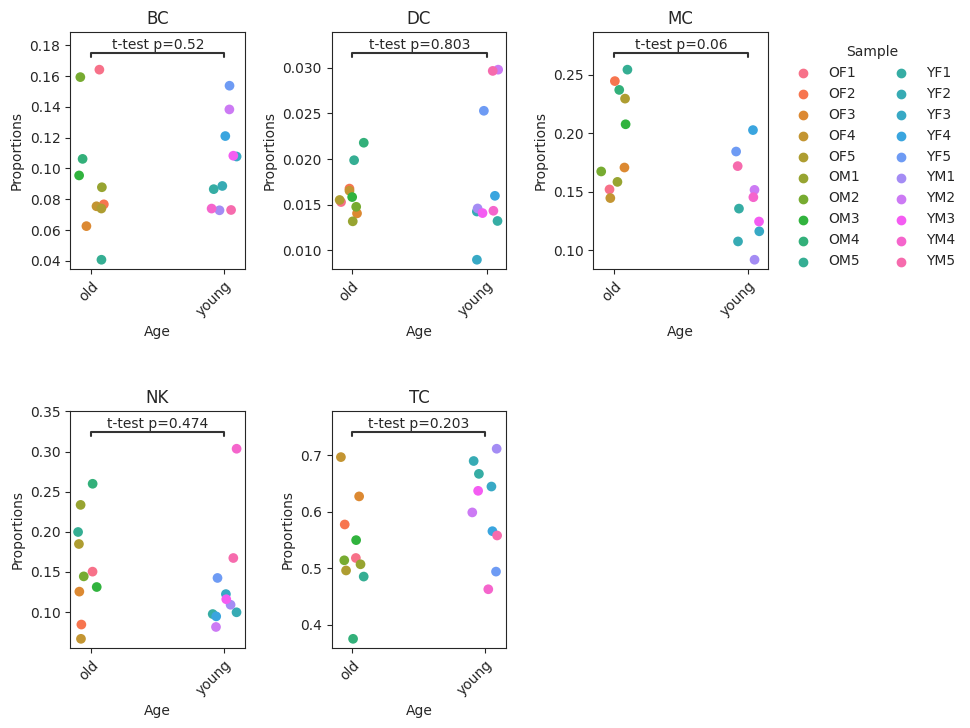

In [9]:
pbmc_young_old.plot(save="plots/pbmc_age_stripplot.pdf")

#### With sex as covariate

In [10]:
pbmc_young_old_sex = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Age', 
                                     covariates=["Sex"])
pbmc_young_old_sex.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_old,mean_props_young,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
BC,0.098383,0.094222,0.102401,0.920131,-0.847305,0.399205,0.499006
DC,0.017112,0.016362,0.018018,0.908097,-0.240203,0.810751,0.810751
MC,0.171416,0.196655,0.143211,1.373180,2.446304,0.016494,0.082471
NK,0.146479,0.158121,0.133477,1.184627,1.220507,0.225648,0.376080
TC,0.566610,0.534640,0.602892,0.886791,-1.782987,0.078158,0.195396


### Male vs Female

In [11]:
pbmc_male_female = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex')
pbmc_male_female.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_female,mean_props_male,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
BC,0.098383,0.101042,0.095581,1.057138,0.453598,0.651210,0.814013
DC,0.017112,0.015587,0.018793,0.829422,-1.054917,0.294287,0.490479
MC,0.171416,0.168821,0.171046,0.986995,-0.063599,0.949430,0.949430
NK,0.146479,0.116914,0.174684,0.669285,-2.636203,0.009874,0.049371
TC,0.566610,0.597636,0.539896,1.106946,1.447690,0.151178,0.377946


In [12]:
pbmc_male_female.results.to_csv("results/pbmc_scanpro_rep.tsv", sep="\t")

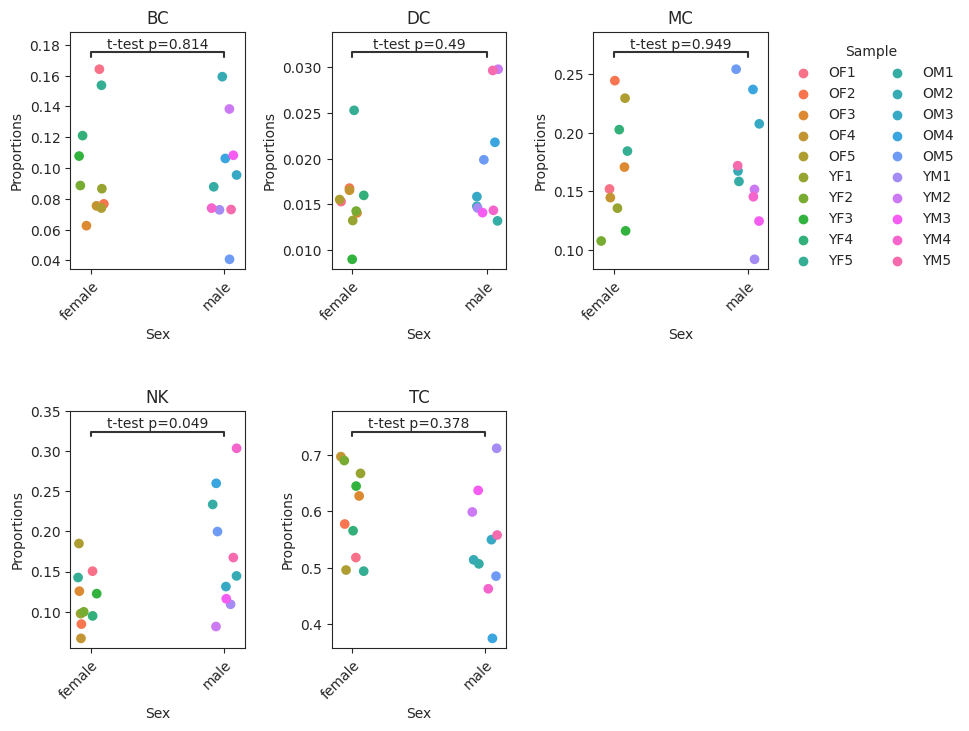

In [13]:
pbmc_male_female.plot(save=f"{FIG_PATH}/pbmc_sex_stripplot.pdf")

#### With age as covariate

In [14]:
pbmc_male_female_age = scanpro.scanpro(pbmc, samples_col='Sample', clusters_col='Celltype', conds_col='Sex', covariates="Age")
pbmc_male_female_age.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_female,mean_props_male,prop_ratio,t_statistics,p_values,adjusted_p_values
clusters,,,,,,,
BC,0.098383,0.101042,0.095581,1.057138,0.466193,0.642270,0.802838
DC,0.017112,0.015587,0.018793,0.829422,-1.094385,0.276878,0.461463
MC,0.171416,0.168821,0.171046,0.986995,-0.066020,0.947517,0.947517
NK,0.146479,0.116914,0.174684,0.669285,-2.699387,0.008380,0.041900
TC,0.566610,0.597636,0.539896,1.106946,1.496382,0.138258,0.345645


## Run Scanpro without replicates

In [15]:
pbmc_male_female_norep = scanpro.scanpro(pbmc, clusters_col='Celltype', conds_col='Sex')

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 37.24 seconds


In [16]:
pbmc_male_female_norep.results.to_csv("results/pbmc_scanpro_norep.tsv", sep="\t")

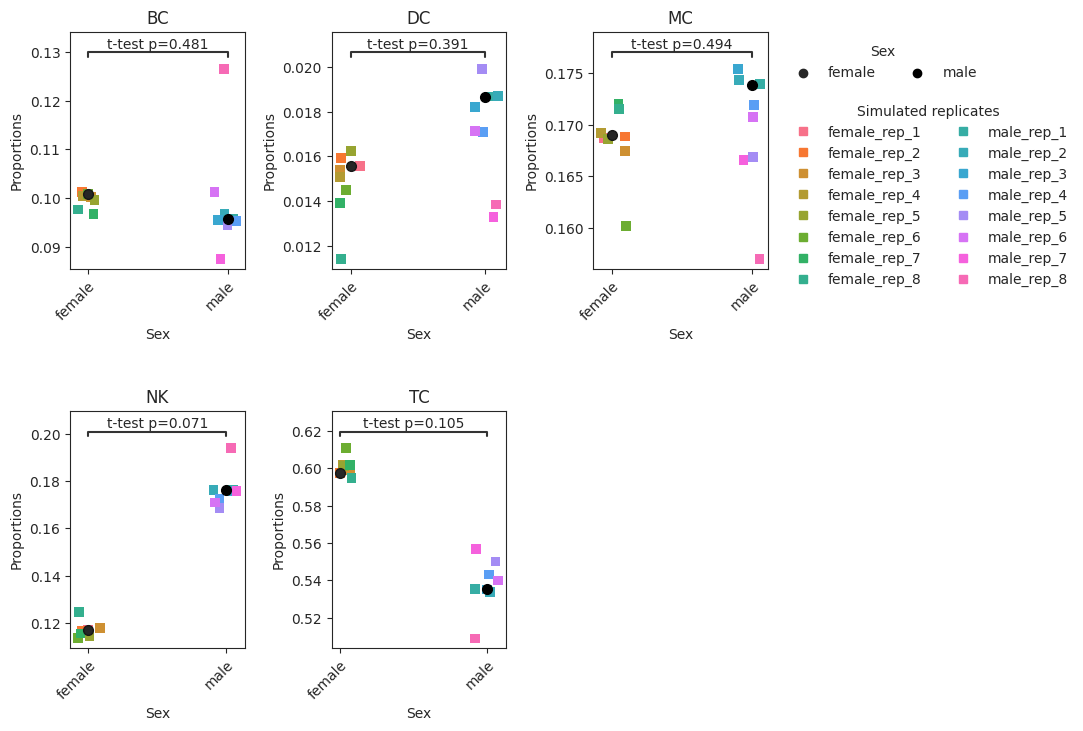

In [17]:
pbmc_male_female_norep.plot(save="plots/pbmc_sex_norep_stripplot.pdf")

-----------------------

## Run propeller

In [18]:
%%R -i pbmc -o propeller_results
library(speckle)

propeller_results = propeller(clusters = pbmc$Celltype, sample = pbmc$Sample, group = pbmc$Sex)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed


In [19]:
propeller_results

,BaselineProp.clusters,BaselineProp.Freq,PropMean.female,PropMean.male,PropRatio,Tstatistic,P.Value,FDR
NK,NK,0.146479,0.116914,0.174684,0.669285,-2.637317,0.009844,0.049221
TC,TC,0.566610,0.597636,0.539896,1.106946,1.448420,0.150975,0.377437
DC,DC,0.017112,0.015587,0.018793,0.829422,-1.052536,0.295371,0.492285
BC,BC,0.098383,0.101042,0.095581,1.057138,0.453546,0.651248,0.814059
MC,MC,0.171416,0.168821,0.171046,0.986995,-0.063694,0.949355,0.949355


In [20]:
propeller_results.to_csv("results/pbmc_propeller_rep.tsv", sep="\t")

-------------

## Run scCODA

### Data preparation

In [21]:
# With replicates
sccoda_data = dat.from_pandas(pbmc_counts, covariate_columns=["Sample", "Condition", "Age", "Sex"])

# Without replicates
counts_merged = pbmc_counts.groupby("Sex").sum(numeric_only=True).reset_index()
sccoda_data_norep = dat.from_pandas(counts_merged, covariate_columns=["Sex"])

### With replicates

In [22]:
sccoda_model = mod.CompositionalAnalysis(sccoda_data, formula="Sex", reference_cell_type="automatic")
sccoda_results = sccoda_model.sample_hmc()

Automatic reference selection! Reference cell type set to DC
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-07-11 22:34:35.888062: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f67e4167d90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-11 22:34:35.888124: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/20000 [00:00<?, ?it/s]2023-07-11 22:34:35.960090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-11 22:34:36.679924: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 20000/20000 [02:09<00:00, 153.91it/s]


MCMC sampling finished. (169.465 sec)
Acceptance rate: 0.0%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [23]:
sccoda_results.summary()

Compositional Analysis summary:

Data: 20 samples, 5 cell types
Reference index: 1
Formula: Sex

Intercepts:
           Final Parameter  Expected Sample
Cell Type                                  
BC                  -3.144       223.486432
DC                  -1.101      1723.910793
MC                 -14.530         0.002537
NK                  -3.450       164.572418
TC                   0.243      6610.077819


Effects:
                       Final Parameter  Expected Sample  log2-fold change
Covariate   Cell Type                                                    
Sex[T.male] BC             -181.449889    7.949546e-286       -954.884606
            DC                0.000000    3.893063e-206       -693.107751
            MC             -499.746031     0.000000e+00              -inf
            NK                0.000000    3.716496e-207       -693.107751
            TC              480.702942     8.722050e+03          0.400000


In [24]:
sccoda_out =sccoda_results.credible_effects().to_frame(name="credible_effect")
sccoda_out.to_csv("results/pbmc_sccoda_rep.tsv", sep="\t")
sccoda_out

credible_effect
Covariate   Cell Type                 
Sex[T.male] BC                    True
            DC                   False
            MC                    True
            NK                   False
            TC                    True

### Without replicates

In [25]:
credeff_list = []
for _ in range(10):
    pbmc_model_norep = mod.CompositionalAnalysis(sccoda_data_norep, formula="Sex", reference_cell_type="automatic")
    sccoda_results_norep = pbmc_model_norep.sample_hmc()
    credeff_list.append(sccoda_results_norep.credible_effects())

Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:05<00:00, 158.81it/s]


MCMC sampling finished. (160.414 sec)
Acceptance rate: 4.3%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:05<00:00, 159.44it/s]


MCMC sampling finished. (159.244 sec)
Acceptance rate: 13.8%
Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:02<00:00, 162.71it/s]


MCMC sampling finished. (155.805 sec)
Acceptance rate: 11.9%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:06<00:00, 157.90it/s]


MCMC sampling finished. (158.783 sec)
Acceptance rate: 2.2%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:08<00:00, 155.74it/s]


MCMC sampling finished. (160.670 sec)
Acceptance rate: 11.1%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:02<00:00, 163.41it/s]


MCMC sampling finished. (154.664 sec)
Acceptance rate: 55.1%
Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:05<00:00, 159.26it/s]


MCMC sampling finished. (158.136 sec)
Acceptance rate: 5.3%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:04<00:00, 160.66it/s]


MCMC sampling finished. (157.643 sec)
Acceptance rate: 0.0%


/home/yalayou/.conda/envs/pypropeller/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:04<00:00, 160.78it/s]


MCMC sampling finished. (161.071 sec)
Acceptance rate: 64.9%
Automatic reference selection! Reference cell type set to MC


100%|██████████| 20000/20000 [02:08<00:00, 155.15it/s]


MCMC sampling finished. (165.041 sec)
Acceptance rate: 21.2%


In [26]:
# Collect credible effects
all_credeff = pd.concat(credeff_list)
pct_credeff = all_credeff.groupby(all_credeff.index.names).mean().to_frame("pct_credible_effect") * 100
pct_credeff

pct_credible_effect
Covariate   Cell Type                     
Sex[T.male] BC                        30.0
            DC                        20.0
            MC                         0.0
            NK                        60.0
            TC                        50.0

In [27]:
pct_credeff.to_csv("results/pbmc_sccoda_norep.tsv", sep="\t")